In [17]:
#####################################################
################## PACKAGES #########################
#####################################################
import pandas as pd
import sys 
import base64
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import random
from sklearn.metrics import accuracy_score, roc_auc_score
from datetime import datetime, timedelta, date
from itertools import combinations
from numpy.linalg import norm
import pickle
import os
import torch.nn as nn
import torch
from torch.nn import Linear
import torch.nn.functional as F
import altair as alt
from altair import expr, datum
from vega_datasets import data
from geopy.geocoders import Nominatim
from tqdm import tqdm
import os
import random
import shutil
import time

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from utils import *

tqdm.pandas()
DATA_PATH = './data'

important source : https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/

In [2]:
split_total_images_folder(DATA_PATH)

Split has already been done. Exiting...


In [57]:
# https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/
image_transforms = { 
    'train': transforms.Compose([
        # transforms.Grayscale(),
        # transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
        # transforms.RandomRotation(degrees=15),
        # transforms.RandomHorizontalFlip(),
        # transforms.CenterCrop(size=64),
        transforms.ToTensor()
    ]),

    'valid': transforms.Compose([
        # transforms.Grayscale(),
        # transforms.Resize(size=64),
        # transforms.CenterCrop(size=64),
        transforms.ToTensor()
    ])
}

data, train_data, val_data, train_data_size, val_data_size = dataset_creation(image_transforms, DATA_PATH, bs=16)

In [ ]:
labels_map = {
    0: "no_plume",
    1: "plume"
}
#num classes
num_classes = 2
plot_images(data, labels_map, cols=3, rows=3)

# Training

In [78]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), 
    nn.Softmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
resnet50 = resnet50.to('cpu')

# Define Optimizer and Loss Function
loss_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters())

In [84]:
def train(model, epochs, loss_criterion, train_data, val_data, device, model_name, performances_df=None):
    
    if performances_df == None:
        performances_df = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss', 'train_accu', 'val_accu', 'train_auc', 'val_auc'])
    
    best_loss = np.inf
    
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        # Set to training mode
        resnet50.train()
        # Loss and Accuracy within the epoch
        train_loss = []
        train_accu = []
        train_auc = []

        val_loss = []
        val_accu = []
        val_auc = []

        for i, (inputs, labels) in enumerate(train_data):
            ################
            ###  TRAIN   ###
            ################
            inputs = inputs.to(device)
            labels = labels.to(device)
            numpy_labels = labels.cpu().bool().numpy()
            # Clean existing gradients
            optimizer.zero_grad()
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            ## LOSS ##

            # Compute loss
            loss = loss_criterion(outputs, labels)
            # Backpropagate the gradients
            loss.backward()
            # Update the parameters
            optimizer.step()
            # Compute the total loss for the batch and add it to train_loss
            train_loss.append(loss.item())

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            train_accu.append(accuracy_score(numpy_labels,predictions.cpu().bool().numpy()))
            
            #compute auc_roc
            probas_plume = outputs[:,-1:].detach().cpu().numpy()
            try:
                train_auc.append(roc_auc_score(numpy_labels, probas_plume))
            except:
                print('Only one class in y_true !!')
                train_auc.append(0)

            ################
            ###  VALID   ###
            ################
            model.eval()
            with torch.no_grad():
                for i, (inputs, labels) in enumerate(val_data):

                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    numpy_labels = labels.cpu().bool().numpy()
                    outputs = model(inputs)

                    # Compute loss
                    loss = loss_criterion(outputs, labels)
                    val_loss.append(loss.item())

                    # Compute the accuracy
                    ret, predictions = torch.max(outputs.data, 1)
                    val_accu.append(accuracy_score(numpy_labels, predictions.cpu().bool().numpy()))
                    
                    #compute auc_roc
                    probas_plume = outputs[:,-1:].detach().cpu().numpy()
                    try:
                        val_auc.append(roc_auc_score(numpy_labels, probas_plume))
                    except:
                        print('Only one class in y_true !!')
                        val_auc.append(0)

        val_loss = np.mean(val_loss)
        performances_df.loc[len(performances_df)] = [
                                                    epoch, np.mean(train_loss), val_loss, 
                                                    np.mean(train_accu), np.mean(val_accu),
                                                    np.mean(train_auc), np.mean(val_auc)
                                                    ]

        if epoch%5 == 0:
            print(f"Epoch: {epoch:03d} | Train loss: {np.mean(train_loss):.4f} | Val loss: {val_loss:.4f} | Train Accu: { np.mean(train_accu):.4f} | Val Accu: {np.mean(val_accu):.4f} | Train AUC: { np.mean(train_auc):.4f} | Val AUC: { np.mean(val_auc):.4f} ")


        #save best model
        if val_loss < best_loss:
            torch.save(model, DATA_PATH+f'/models/{model.__class__.__name__}_{model_name}.pt')
            best_loss = val_loss

    return performances_df

In [80]:
performances_df = train(resnet50, 10, loss_criterion, train_data, val_data, device='cpu', model_name='pretrained_resnet50')

Epoch: 1/10
Epoch: 000 | Train loss: 0.6606 | Val loss: 0.7087 | Train Accu: 0.5995 | Val Accu: 0.5309 | Train AUC: 0.6641 | Val AUC: 0.6214 
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 005 | Train loss: 0.5117 | Val loss: 0.5371 | Train Accu: 0.7994 | Val Accu: 0.7346 | Train AUC: 0.8836 | Val AUC: 0.8971 
Epoch: 7/10
Epoch: 8/10
Only one class in y_true !!
Epoch: 9/10
Epoch: 10/10


<Axes: >

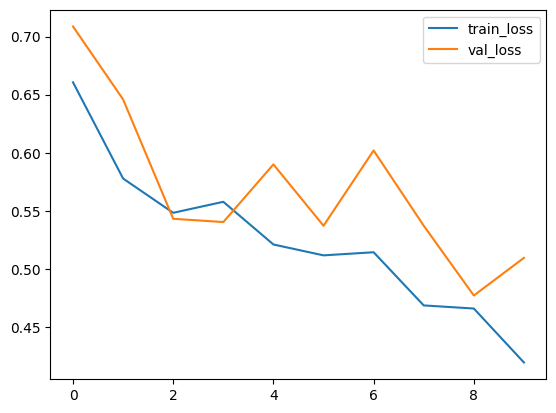

In [81]:
performances_df[['train_loss', 'val_loss']].plot()

<Axes: >

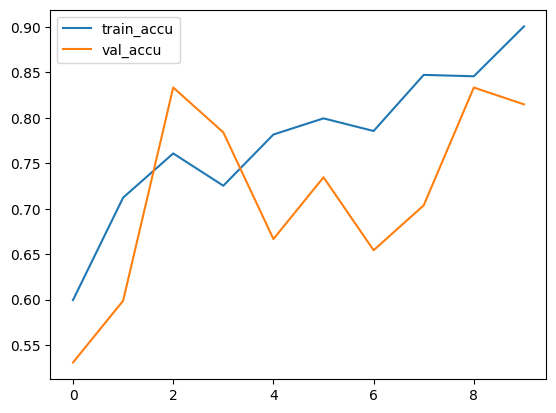

In [82]:
performances_df[['train_accu', 'val_accu']].plot()

<Axes: >

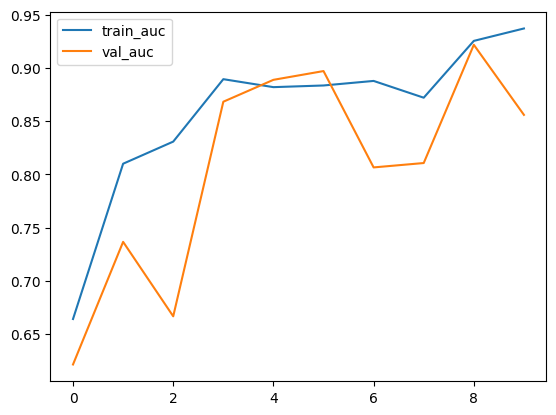

In [83]:
performances_df[['train_auc', 'val_auc']].plot()